In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error, f1_score 


In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m1.csv')
df.head()

,user_id,timestamp,event,params,age,gender
0,668300627f964509a7f5b5f63b570d55,2024-02-18,first_visit,{'source': 'sns'},31,M
1,668300627f964509a7f5b5f63b570d55,2024-03-04,visit,NaN,31,M
2,668300627f964509a7f5b5f63b570d55,2024-03-16,visit,NaN,31,M
3,668300627f964509a7f5b5f63b570d55,2024-03-30,visit,NaN,31,M
4,668300627f964509a7f5b5f63b570d55,2024-04-26,visit_and_purchase,{'product': 'Clothing'},31,M


✅ 전처리 & EDA

In [3]:
# Params dictionary 처리 
df['param_dic'] = df['params'].fillna('{}').map(eval)

# Source / Product 생성 
df['source'] = df['param_dic'].str['source']
df['product'] = df['param_dic'].str['product']

# 시간
df['timestamp'] = pd.to_datetime(df['timestamp'])

<Axes: xlabel='timestamp', ylabel='count'>

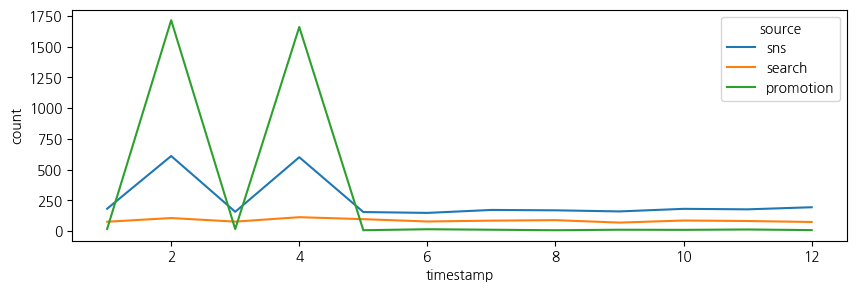

In [4]:
plot_df = df.groupby(df['timestamp'].dt.month)['source'].value_counts().reset_index()

plt.figure(figsize = (10, 3))
sns.lineplot(x = 'timestamp', y ='count', hue = 'source', data = plot_df)

In [5]:
# 첫 방문
first = df[df.event =='first_visit'][['user_id','timestamp']].rename(columns ={'timestamp':'first_visit_time'}).reset_index(drop=True)

# 첫 방문과 데이터 결합 : 첫방문 이후의 날짜의 차이 구하기 
m_df = pd.merge(df , first)
m_df['day_diff'] = (m_df['timestamp'] - m_df['first_visit_time']).dt.days

# 유저 7일차/ 31일차 재 방문율
len(m_df[m_df['day_diff'] == 7] )/ len(m_df.user_id.unique())
len(m_df[m_df['day_diff'] == 31] )/ len(m_df.user_id.unique())

0.028798277486206433

✅ 가입 후 한달동안의 유저 행동을 통해 다음달 첫주 동안의 물건 구매 여부를 확인하는 모델링을 진행

In [6]:
# 가입 후 한달 
df2 = m_df.copy()
df2 = df2.loc[df2.day_diff < 31].reset_index(drop = True)

# 방문 & 구매 = 1 로 치환 
df2['purchase'] = df2.apply(lambda x : 1 if x['event'] == 'visit_and_purchase' else 0 , axis = 1)
df2 = df2.drop(columns = ['params', 'param_dic'], axis = 1)

In [7]:
# source, product 라벨 인코딩 
df2['new_param'] = df2['source'].astype(str) + '_' + df2['product'].astype(str)

In [8]:
num_df = df2[['age','gender','day_diff','purchase']]
dummies_df = pd.get_dummies(df2['new_param'], dtype = 'int')

model_df = pd.concat([num_df, dummies_df], axis = 1) 

가입일 포함 첫 31일 동안의 유저 행동을 통해 32일째 부터 7일동안의 물건 구매 여부를 확인하는 모델링 </br>
 풀이방법] </br>
1. 첫 가입 일자를 구하기 </br>
2. day_diff 로 날짜 차이 구하기</br>
3. 가입 30일 안에 드는 그룹 구하기 = g </br>
         3.1 처음 방문한 user_id별 소스, 나이, 성별 (basic_info)</br>
         3.2 가입 30일 안에 든 user_id에서 visit_and_purchase의 총 구매 건수 (total_purchase)</br>
         3.3 가입 30일 안에 든 user_id에서 visit_and_purchase의 제품별 구매건수를 user_id기준 행/열 치환 (products)</br>
         3.4 가입 30일 안에 든 user_id에서 visit 의 방문 횟수 (visit)</br> 
4. 3번 항목 병합 (user_id 기준)

In [9]:
# 첫 가입 일짜 구하기 
df['first_joined_day'] = df.groupby(['user_id'])['timestamp'].transform(lambda x : x.min())

# 날짜 차이
df['day_diff'] = (df['timestamp'] - df['first_joined_day']).dt.days

In [10]:
# 1. 가입 30일 안에 유저들 그룹 
g = df.loc[df['day_diff'] <= 30].reset_index(drop = True)

# 처음 방문한 사용자의 아이디, 소스, 나이, 성별 - 7431 
basic_info = g[g.event == 'first_visit'][['user_id','source','age','gender']].reset_index(drop = True)
basic_info.head(3)

,user_id,source,age,gender
0,668300627f964509a7f5b5f63b570d55,sns,31,M
1,5247c14484884949b5aa036cc68219f5,sns,47,M
2,3e2b6f742974459eba9d3aaa22f6da9c,sns,32,F


In [11]:
# 총 구매 횟수 - 3490
total_purchase = g[g.event == 'visit_and_purchase']['user_id'].value_counts().reset_index().rename(columns = {'count' :'total_purchase'}) 
total_purchase.head(3)

,user_id,total_purchase
0,b863bcb3866c4b0fb0a80f15d60bfb58,4
1,d946b67c899e4863afde979e581e6cb1,4
2,c141521cca514cc189ff6f0d06d9db62,4


In [12]:
# 각 물품별 구매 횟수 - 3490
products = g[g.event  == 'visit_and_purchase'].groupby(['user_id','product']).size().unstack().fillna(0).astype(int).reset_index() 
products.head(3)

product,user_id,Beauty Products,Books,Clothing,Electronics,Groceries,Home & Kitchen,Movies & TV,Music,Sports,Toys
0,001d54a6141b41e0b44b01e5512b37e4,0,0,0,0,0,0,1,0,0,0
1,002564a18b32492e9993f9bb09a570f7,0,0,0,0,1,1,0,0,0,0
2,0025f3db50064e068aa9a515411b4cc0,0,0,0,1,0,1,0,0,0,0


In [13]:
# 방문 횟수 4631
visit = g[g.event == 'visit']['user_id'].value_counts().reset_index().rename(columns = {'count' :'visit_cnt'})
visit.head(3)

,user_id,visit_cnt
0,922f7952e9514a848aec7a7425865da5,5
1,a99e8f7238024679b4f742590d914e5c,5
2,2d08b20277c2473da4cca08190b2c250,5


In [14]:
m1 = pd.merge(basic_info, total_purchase, how = 'outer', on = 'user_id')
m2 = pd.merge(m1, products, how = 'outer', on = 'user_id')
m3 = pd.merge(m2, visit, how = 'outer', on = 'user_id')

m3= m3.fillna(0)

In [15]:
# 1. 가입 31에서 37 사이에 있는 유저들 그룹 - 구매한 아이디들 
g3137 = df.loc[(df.day_diff >=31) & (df.day_diff <=37)].reset_index(drop = True)

y = g3137.groupby(['user_id', 'event']).size().unstack()['visit_and_purchase'].fillna(0).reset_index()


In [16]:
model = pd.merge(m3, y, how = 'outer', on = 'user_id').fillna(0)
model.head()

,user_id,source,age,gender,total_purchase,Beauty Products,Books,Clothing,Electronics,Groceries,Home & Kitchen,Movies & TV,Music,Sports,Toys,visit_cnt,visit_and_purchase
0,001ce1bb72964d909bc319705b8ffdbf,promotion,48,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,001cec87aa1f4527b488781176ea3f25,sns,25,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,001d54a6141b41e0b44b01e5512b37e4,sns,44,F,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0024a606685141279f350d2fdfeb9f9a,sns,28,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,002564a18b32492e9993f9bb09a570f7,sns,45,F,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


✅ 비트코인 가격 데이터

In [17]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m2.csv')
df.head()

,TIMESTAMP,bitcoin($)
0,1.577837e+09,7195.24
1,1.577837e+09,7187.67
2,1.577837e+09,7184.41
3,1.577837e+09,7183.83
4,1.577837e+09,7185.54


✅ 결측치 대치 방안 - 시계열 데이터(보간법)

In [18]:
df.columns = ['time','value']
df['time'] = pd.to_datetime(df['time'], unit = 's')
df.head()

df1 = df.interpolate(method = 'linear')

✅ 데이터의 정상성을 통계적,시각적 방법을 통해 확인 </br>
1. Adufuller 
 - 귀무가설 : 비정상 데이터다 (v)
 - 대립가설 : 정상 데이터다.

2. plot_acf, plot_pacf 

0.6911875407269488


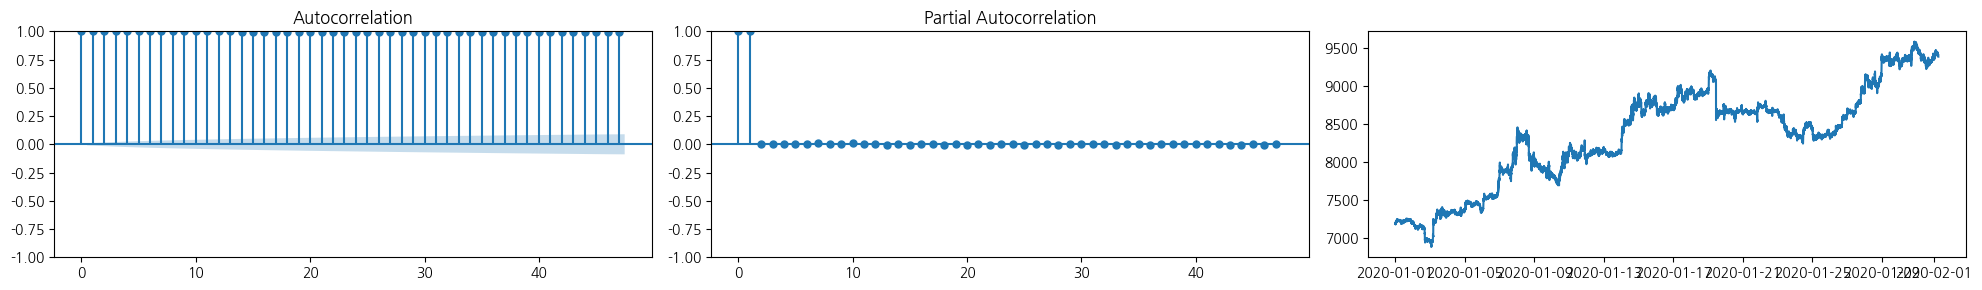


1. ACF 그래프 
    - 정상 : ACF값이 빠르게 0에 수렴, lag가 증가함에 따라 급격히 감소 
    - 비정상 : ACF가 천천히 감소하거나, 지속적으로 높은 상관계수 유지 
     지속적인 자기 상관이 있음 (전형적인 비정상 패턴)
2. PACF 그래프 
    - 정상 : PACF 값이 특정 시차 이후 0에 수렴 
    - 비정상 : PACF 값이 지속적으로 유의미한 값을 가짐
    Lag 1에서만 큰 값을 가지고 있으며, AR(1)을 시사하지만, ACF 그래프에 기반하여 정상성 띄지 않음 



In [19]:
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

result = adfuller(df1['value'])
print(result[1])

fig, ax = plt.subplots(1,3, figsize = (20, 3))
plot_acf(df1['value'], ax = ax[0])
plot_pacf(df1['value'], ax = ax[1])
plt.plot(df1['time'], df1['value'] )

plt.tight_layout()
plt.show()

print('''
1. ACF 그래프 
    - 정상 : ACF값이 빠르게 0에 수렴, lag가 증가함에 따라 급격히 감소 
    - 비정상 : ACF가 천천히 감소하거나, 지속적으로 높은 상관계수 유지 
     지속적인 자기 상관이 있음 (전형적인 비정상 패턴)
2. PACF 그래프 
    - 정상 : PACF 값이 특정 시차 이후 0에 수렴 
    - 비정상 : PACF 값이 지속적으로 유의미한 값을 가짐
    Lag 1에서만 큰 값을 가지고 있으며, AR(1)을 시사하지만, ACF 그래프에 기반하여 정상성 띄지 않음 
''')

<Figure size 2000x300 with 0 Axes>

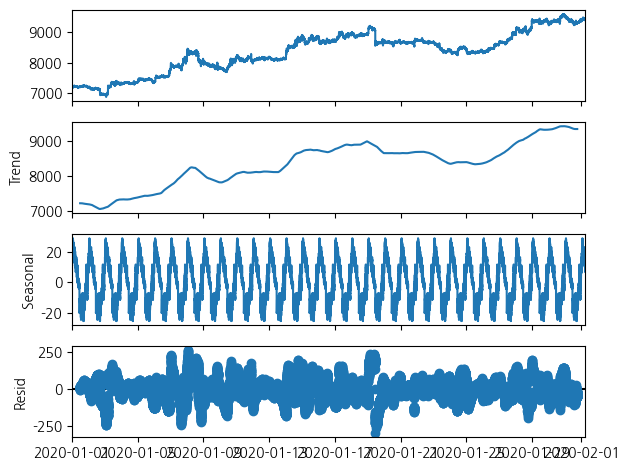


데이터가 추세, 계절성을 가지고 있기 때문에 차분/변환을 통해 정상성을 확보 한 후 모델에 적용하는것이 필요



In [20]:
result = seasonal_decompose(df1.set_index('time'), model='additive', period=1440)

plt.figure(figsize = (20,3))
result.plot()
plt.show()
print('''
데이터가 추세, 계절성을 가지고 있기 때문에 차분/변환을 통해 정상성을 확보 한 후 모델에 적용하는것이 필요
''')

### 🔍 통계
##### ✅ 1. 비모수검정

| 피험자   | 차량 A | 차량 B | 차량 C |
|----------|--------|--------|--------|
| 피험자1 |   4    |   1    |   6    |
| 피험자2 |   3    |   4    |   6    |
| 피험자3 |   2    |   4    |   6    |
| 피험자4 |   4    |   3    |   2    |
| 피험자5 |   4    |   1    |   6    |
| 피험자6 |   6    |   4    |   2    |
| 피험자7 |   5    |   3    |   5    |
| 피험자8 |   6    |   3    |   2    |
| 피험자9 |   2    |   4    |   6    |


In [27]:
# 차량의 쌍별로 비교 - 프리드만 
from scipy.stats import friedmanchisquare , chi2_contingency

A = [4,3,2,4,4,6,5,6,2]
B = [1,4,4,3,1,4,3,3,4]
C = [6,6,6,2,6,2,5,2,6]

s, p_val = friedmanchisquare(A,B,C)
print(p_val)

0.4124194827001596


##### ✅ 2. 장르별 팝콘 구매여부

In [25]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s2.csv')
df.head()

,유저ID,장르,구매여부
0,0,액션,구매
1,1,액션,구매
2,2,액션,구매
3,3,액션,구매
4,4,액션,구매


In [28]:
tab = pd.crosstab(df['장르'] , df['구매여부'])

stat, p_val, _, _ = chi2_contingency(tab)
print(p_val)

4.987377462630171e-14


#### 📦 크라메르 연관계수 
두 범주형 변수간의 연관성을 측정하는 지표 (카이 제곱 통계량 기반)
- 0에 가까울 수록 연관성 없음
- 1에 가까울 수록 강한 연관성
- 0.6d 이상 강한 연관 / 0.2 ~ 0.6 적당히 연관

In [34]:
# cross_tab의 구매여부의 합 
total = tab.sum().sum()

# row 혹은 column 수 중 작은 값
k = min(tab.shape) 

np.sqrt(stat / total * (k -1))

np.float64(0.32916973606033734)

##### ✅ 3. 어느 도시에서 성인 전체의 25%가 흡연자라고 한다. 만약 현재도 이와 비슷한 비율이 유지된다면 1300명의 성인표본에서 흡연자가 317명보다 작을 확률 

In [43]:
from scipy.stats import norm, binom
#이항분포는 𝑛이 크고 p가 중간값(0.5 근처)일 때 정규분포로 근사 > N이 1300명임으로 정규분포로 풀이 

p = 0.25 
n = 1300 
x = 316.5  # 연속성 보정 적용

mean = n * p 
se = np.sqrt(n * p * (1-p))
# Z점수
z = (x - mean) / se 

print(norm.cdf(z))


# <이항 풀이 참고> 
p = 0.25 
n = 1300 
x = 317

rv = binom(n, p)
# 317보다 작을 확률 : 316이하 
rv.cdf(x - 1)

0.29307083446132876


np.float64(0.2943747986304395)

##### ✅ 4. 사용자가 게임 내에서 특정 퀘스트를 클리어하는 성공 확률이 0.3
1) 사용자가 총 3회의 성공을 하기까지 시도한 횟수가 5회 미만일 확률
2) 사용자가 4번의 퀘스트 클리어 성공을 경험하기까지 평균적으로 몇 번의 시도

In [45]:
# 음이항 분포 : r번째 성공을 달성하기 까지의 시도 횟수 
from scipy.stats import nbinom
p = 0.3 
r = 3      #목표 성공 수

# 1) r번째 성공이 K번째 시행에서 이루어질 확률 
# nbinom.pmf(k-r, r, p)
# 4-r : 3회 성공 = 4번 이하의 시도 
prob = nbinom.cdf(4-r, r, p)
print(prob)

0.0837


In [47]:
# 2) 음이항 분포의 평균 구하기 : E(x) = r / p 
rv = nbinom(4, 0.3)
rv.mean() + 4 

np.float64(13.333333333333334)

##### ✅ 5. 일반화 선형 모형 
1) 종속 변수가 정규분포가 아닌 경우
2) 종속 변수가 이진/카운트/비율/양수형 등 일때
   * 질병 유무 - 로지스틱 / 하루의 교통사고 수- 포아송 / 생존 시간- 감마

In [49]:
import statsmodels.api as sm
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s5.csv')
df.head()

,Year,Population,Attacks
0,1946,2473000,0
1,1947,2539000,1
2,1948,2578000,0
3,1949,2668000,0
4,1950,2771305,1


In [50]:
df['Population']= np.log(df['Population'] / 1000)

In [55]:
# 3. 포아송 회귀 모델 정의 
#  offset : 포아송 회귀에서는 종속 변수가 카운트임으로, 시간, 사람수, 면적등을 반옇아여 보정항을 생성 > 인구수 보정
model = sm.GLM(df['Attacks'] , 
                   sm.add_constant(df['Year']) ,
                   family = sm.families.Poisson(), 
                   offset = df['Population'])
result = model.fit()

In [56]:
# 4. 예측값 생성 
df['pred'] = result.predict(sm.add_constant(df['Year']), offset = df['Population'])

# 5. 출력 
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Attacks   No. Observations:                   54
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -142.38
Date:                Thu, 17 Apr 2025   Deviance:                       119.11
Time:                        20:46:32   Pearson chi2:                     118.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6573
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -68.8845      8.658     -7.956      0.0

In [57]:
#  2000년도에 인구가 16224544라고 할 때 상어 공격횟수를 예측한 값을 출력
result.predict([1,2000], offset = np.log(16224544/1000))

array([23.51581604])